In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing
from sklearn import svm

## Original Image

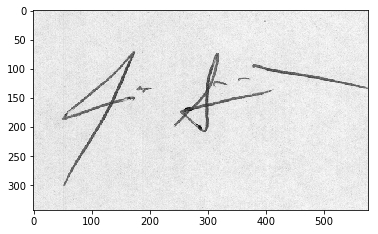

In [2]:
img = cv2.imread('D:\\MY-DOC\\Desktop\\signatures\\full_org\\original_1_1.png',0)
#img = cv2.imread('D:\\MY-DOC\\Desktop\\testing.png',0)
plt.imshow(img,'gray')
plt.show()


## Applying Gaussian Blurring and Otsu Thresholding for Binarization

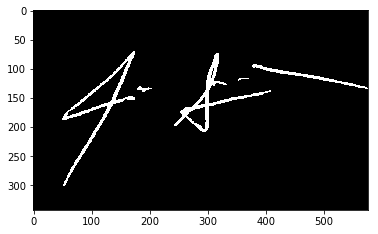

In [3]:
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
image=np.invert(th3)
plt.imshow(image,'gray')
plt.show()


## Cropping image to get bounding box

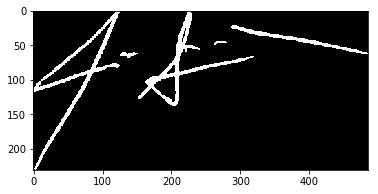

In [4]:
def crop_image(img,tol=0):
    # img is image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

cimg=crop_image(image,tol=0)
plt.imshow(cimg,'gray')
plt.show()

## Thinning the image

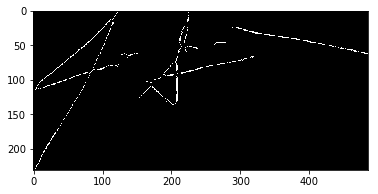

In [5]:
def thinning(img):
    #img = cimg
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True

  #  plt.imshow(skel,'gray')
   # plt.show()
    return skel

timg=thinning(cimg)
plt.imshow(timg,'gray')
plt.show()

## Finding number of white pixels and connected components in signature

In [6]:
#Feature generation area
area=cv2.countNonZero(cimg)
print(area)
img1=np.invert(cimg)
cc=cv2.connectedComponents(img1)[0]
print(cc)


6511
8


## Dividing image into 4 parts

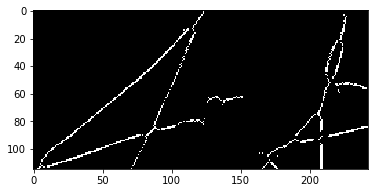

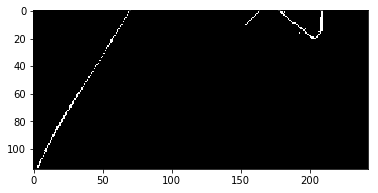

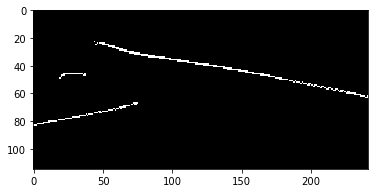

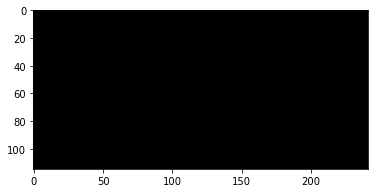

In [7]:
def coords(timg):
    rows,cols=timg.shape
    img_tl=timg[0:int(rows/2),0:int(cols/2)]
    img_tr=timg[int(rows/2)+1:rows,0:int(cols/2)]
    img_bl=timg[0:int(rows/2),int(cols/2)+1:cols]
    img_br=timg[int(rows/2)+1:rows,int(cols/2)+1:cols]
    
    tl_x,tl_y=COG(img_tl)
    tr_x,tr_y=COG(img_tr)
    bl_x,bl_y=COG(img_bl)
    br_x,br_y=COG(img_br)

    return tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y



rows,cols=timg.shape
img_tl=timg[0:int(rows/2),0:int(cols/2)]
img_tr=timg[int(rows/2)+1:rows,0:int(cols/2)]
img_bl=timg[0:int(rows/2),int(cols/2)+1:cols]
img_br=timg[int(rows/2)+1:rows,int(cols/2)+1:cols]

#fig,ax=plt.subplots(nrows=1,ncols=1)
#plt.subplot(2,2,1)    
plt.imshow(img_tl,'gray')
plt.show()

plt.imshow(img_tr,'gray')
plt.show()

plt.imshow(img_bl,'gray')
plt.show()

plt.imshow(img_br,'gray')
plt.show()

  




## Finding Centre of gravity of each sub-image

In [8]:
def COG(img):
    x_cor=0
    xrun_sum=0
    y_cor=0
    yrun_sum=0
    #print(img.shape)
    for i in range(img.shape[0]):
        x_cor+=sum(img[i])*i/255
        xrun_sum+=sum(img[i])/255

    for i in range(img.shape[1]):
        y_cor+=sum(img[:,i])*i/255
        yrun_sum+=sum(img[:,i])/255
        #print(img.shape[1]) 
        if yrun_sum==0:
            x_pos=0
        else:
            x_pos=y_cor/(yrun_sum)
        if xrun_sum==0:
            y_pos=0
        else:
            y_pos=x_cor/(xrun_sum)
        
   # print(x_pos)
  #  print(y_pos)
    
    return (x_pos/img.shape[1],y_pos/img.shape[0])
COG(img_bl)

(0.45169638973466725, 0.43041189931350116)

## Generating feature dataset of original images!

In [54]:
data=[]
#df=pd.DataFrame(columns=["Writer_no","Sample_no","area","connected_comps"])
for i in range(1,56):
   # print(i)
    for j in range(1,25):
        path=f'D:\\MY-DOC\\Desktop\\signatures\\full_org\\original_{i}_{j}.png'
        img = cv2.imread(path,0)
        blur = cv2.GaussianBlur(img,(5,5),0)
        ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image=np.invert(th3)
        
        cimg=crop_image(image,tol=0)
        area=cv2.countNonZero(cimg)/(cimg.shape[0]*cimg.shape[1])
        #Find proportion of white cells
        img1=np.invert(cimg)
        
        cc=cv2.connectedComponents(img1)[0]
        #Generate connected components
        
        timg=thinning(cimg)
        #Thinning the image!
        
        tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y=coords(timg)
        #Extracting features
        
        x=pd.Series([i,j,area,cc,tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y],index=
                    ["Writer_no","Sample_no","area","connected_comps","tl_x","tl_y","tr_x","tr_y","bl_x","bl_y",
                    "br_x","br_y"])
        data.append(x)
df=pd.DataFrame(data)

## Original feature dataset

,Writer_no,Sample_no,area,connected_comps,tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y
155,7.0,12.0,0.042288,22.0,0.0,0.000000,0.545128,0.483002,0.553789,0.454671,0.234599,0.194871
254,11.0,15.0,0.056855,9.0,0.0,0.487289,0.408676,0.267538,0.293677,0.936579,0.444194,0.152059
605,26.0,6.0,0.032066,10.0,0.0,0.000000,0.401220,0.495567,0.548410,0.473342,0.115435,0.119458
878,37.0,15.0,0.061634,12.0,0.0,0.000000,0.352117,0.451172,0.510871,0.430963,0.146516,0.138813


In [55]:
df.head()

,Writer_no,Sample_no,area,connected_comps,tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y
0,1.0,1.0,0.057996,8.0,0.543550,0.610433,0.397434,0.363247,0.451696,0.430412,0.000000,0.000000
1,1.0,2.0,0.053513,7.0,0.561836,0.612942,0.308246,0.446003,0.365957,0.505960,0.055195,0.105993
2,1.0,3.0,0.065649,8.0,0.489149,0.659250,0.422837,0.290790,0.419947,0.561929,0.029383,0.228898
3,1.0,4.0,0.057294,8.0,0.581378,0.681989,0.475747,0.303367,0.434618,0.418442,0.000000,0.000000
4,1.0,5.0,0.059420,7.0,0.546085,0.663264,0.343665,0.380819,0.417940,0.508736,0.085050,0.250539


## Generating forgery feature dataset

In [28]:
data_f=[]
#df=pd.DataFrame(columns=["Writer_no","Sample_no","area","connected_comps"])
for i in range(1,56):
   # print(i)
    for j in range(1,25):
        path=f'D:\\MY-DOC\\Desktop\\signatures\\full_forg\\forgeries_{i}_{j}.png'
        img = cv2.imread(path,0)
        blur = cv2.GaussianBlur(img,(5,5),0)
        ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image=np.invert(th3)
        
        cimg=crop_image(image,tol=0)
        area=cv2.countNonZero(cimg)/(cimg.shape[0]*cimg.shape[1])
        #Find proportion of white cells
        img1=np.invert(cimg)
        
        cc=cv2.connectedComponents(img1)[0]
        #Generate connected components
        
        timg=thinning(cimg)
        #Thinning the image!
        
        tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y=coords(timg)
        #Extracting features
        
        x=pd.Series([i,j,area,cc,tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y],index=
                    ["Writer_no","Sample_no","area","connected_comps","tl_x","tl_y","tr_x","tr_y","bl_x","bl_y",
                    "br_x","br_y"])
        data_f.append(x)
df_f=pd.DataFrame(data_f)

## Forgery features dataset

In [29]:
df_f.head()

,Writer_no,Sample_no,area,connected_comps,tl_x,tl_y,tr_x,tr_y,bl_x,bl_y,br_x,br_y
0,1.0,1.0,0.077251,6.0,0.427607,0.743763,0.587419,0.425577,0.510570,0.726620,0.238213,0.095882
1,1.0,2.0,0.065212,7.0,0.540634,0.662456,0.566038,0.286215,0.508463,0.416757,0.000000,0.000000
2,1.0,3.0,0.045214,5.0,0.469694,0.522363,0.547135,0.352975,0.461879,0.806293,0.163743,0.114939
3,1.0,4.0,0.071579,7.0,0.521529,0.592612,0.594136,0.414448,0.657607,0.717476,0.143615,0.081710
4,1.0,5.0,0.056570,5.0,0.469772,0.529283,0.781120,0.432385,0.290518,0.639652,0.433911,0.313163


## Generating alternate feature dataset
### Splitting the image into 8 parts, then calculating tan inverse of centre of gravity of each part

In [9]:
def tan_i(x):
    #print(x)
    if x[0]==0:
        return 90
    return math.degrees(math.atan(x[1]/x[0]))

def alt_coords(timg):
    rows,cols=timg.shape
    
    img_tl1=timg[0:int(rows/2),0:int(cols/4)]
    img_tl2=timg[0:int(rows/2),int(cols/4)+1:int(cols/2)]
    
    img_tr1=timg[0:int(rows/2),int(cols/2)+1:int(0.75*cols)]
    img_tr2=timg[0:int(rows/2),int(0.75*cols)+1:cols]
    
    img_bl1=timg[int(rows/2)+1:rows,0:int(cols/4)]
    img_bl2=timg[int(rows/2)+1:rows,int(cols/4)+1:int(cols/2)]
    
    img_br1=timg[int(rows/2)+1:rows,int(cols/2)+1:int(0.75*cols)]
    img_br2=timg[int(rows/2)+1:rows,int(0.75*cols)+1:cols]
    

    #plt.imshow(timg,'gray')
    #plt.show()
    
    tl1=tan_i(COG(img_tl1))
    tl2=tan_i(COG(img_tl2))
    tr1=tan_i(COG(img_tr1))
    tr2=tan_i(COG(img_tr2))
    bl1=tan_i(COG(img_bl1))
    bl2=tan_i(COG(img_bl2))
    br1=tan_i(COG(img_br1))
    br2=tan_i(COG(img_br2))
    
    #plt.imshow(img_br1,'gray')
    #plt.show()
    #print(COG(img_br1))
    return tl1,tl2,tr1,tr2,bl1,bl2,br1,br2

alt_coords(timg)

(47.25441111211973,
 41.6276041365979,
 40.553776758207,
 42.222600315942046,
 65.35137463786856,
 7.894060239787955,
 90,
 90)

## Generating alternate original feature dataset

In [10]:
alt_data=[]
#df=pd.DataFrame(columns=["Writer_no","Sample_no","area","connected_comps"])
for i in range(1,56):
   # print(i)
    for j in range(1,25):
        path=f'D:\\MY-DOC\\Desktop\\signatures\\full_org\\original_{i}_{j}.png'
        img = cv2.imread(path,0)
        blur = cv2.GaussianBlur(img,(5,5),0)
        ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image=np.invert(th3)
        
        cimg=crop_image(image,tol=0)
        area=cv2.countNonZero(cimg)/(cimg.shape[0]*cimg.shape[1])
        #Find proportion of white cells
        img1=np.invert(cimg)
        
        cc=cv2.connectedComponents(img1)[0]
        #Generate connected components
        
        timg=thinning(cimg)
        #Thinning the image!
        
        tl1,tl2,tr1,tr2,bl1,bl2,br1,br2=alt_coords(timg)
        #Extracting features
        
        x=pd.Series([i,j,area,cc,tl1,tl2,tr1,tr2,bl1,bl2,br1,br2],index=
                    ["Writer_no","Sample_no","area","connected_comps","tl1","tl2","tr1","tr2","bl1","bl2",
                    "br1","br2"])
        alt_data.append(x)
alt_df=pd.DataFrame(alt_data)

## Alternate original dataset

In [11]:
alt_df.head()

,Writer_no,Sample_no,area,connected_comps,tl1,tl2,tr1,tr2,bl1,bl2,br1,br2
0,1.0,1.0,0.057996,8.0,47.254411,41.627604,40.553777,42.222600,65.351375,7.894060,90.000000,90.0
1,1.0,2.0,0.053513,7.0,43.281829,52.370607,53.274998,45.259958,55.945628,2.811269,43.717199,90.0
2,1.0,3.0,0.065649,8.0,45.875680,58.158984,54.030894,51.247165,53.599163,11.113857,75.496820,90.0
3,1.0,4.0,0.057294,8.0,48.133216,48.463786,46.905308,38.166663,63.384708,8.721940,90.000000,90.0
4,1.0,5.0,0.059420,7.0,48.093205,54.154969,52.784000,44.489192,58.568832,4.797248,55.616980,90.0


## Alternate forgery feature dataset generation

In [12]:
alt_data_f=[]
#df=pd.DataFrame(columns=["Writer_no","Sample_no","area","connected_comps"])
for i in range(1,56):
   # print(i)
    for j in range(1,25):
        path=f'D:\\MY-DOC\\Desktop\\signatures\\full_forg\\forgeries_{i}_{j}.png'
        img = cv2.imread(path,0)
        blur = cv2.GaussianBlur(img,(5,5),0)
        ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image=np.invert(th3)
        
        cimg=crop_image(image,tol=0)
        area=cv2.countNonZero(cimg)/(cimg.shape[0]*cimg.shape[1])
        #Find proportion of white cells
        img1=np.invert(cimg)
        
        cc=cv2.connectedComponents(img1)[0]
        #Generate connected components
        
        timg=thinning(cimg)
        #Thinning the image!
        
        tl1,tl2,tr1,tr2,bl1,bl2,br1,br2=alt_coords(timg)
        #Extracting features
        
        x=pd.Series([i,j,area,cc,tl1,tl2,tr1,tr2,bl1,bl2,br1,br2],index=
                    ["Writer_no","Sample_no","area","connected_comps","tl1","tl2","tr1","tr2","bl1","bl2",
                    "br1","br2"])
        alt_data_f.append(x)
alt_df_f=pd.DataFrame(alt_data_f)

## Alternate forgery dataset

In [13]:
alt_df_f.head()

,Writer_no,Sample_no,area,connected_comps,tl1,tl2,tr1,tr2,bl1,bl2,br1,br2
0,1.0,1.0,0.077251,6.0,49.829491,49.712025,68.060381,63.629942,56.495390,32.474142,11.322624,90.000000
1,1.0,2.0,0.065212,7.0,51.769225,35.785167,50.371876,16.355346,57.695701,21.413331,90.000000,90.000000
2,1.0,3.0,0.045214,5.0,40.500466,52.395254,68.684077,63.814001,52.857117,19.491237,19.264802,90.000000
3,1.0,4.0,0.071579,7.0,47.987451,35.474355,46.917374,52.619889,58.221330,29.034311,15.740051,90.000000
4,1.0,5.0,0.056570,5.0,46.313693,36.112465,86.095989,59.214321,38.392767,31.965372,46.965721,15.057334


# Using One-Class SVM

## Pre-processing data

In [330]:

alt_df.area=preprocessing.scale(alt_df.area)
alt_df.connected_comps=preprocessing.scale(alt_df.connected_comps)
alt_df.tl1=preprocessing.scale(alt_df.tl1)
alt_df.tl2=preprocessing.scale(alt_df.tl2)
alt_df.tr1=preprocessing.scale(alt_df.tr1)
alt_df.tr2=preprocessing.scale(alt_df.tr2)
alt_df.bl1=preprocessing.scale(alt_df.bl1)
alt_df.bl2=preprocessing.scale(alt_df.bl2)
alt_df.br1=preprocessing.scale(alt_df.br1)
alt_df.br2=preprocessing.scale(alt_df.br2)


## Choosing dataset

In [331]:
os=24*32
data=alt_df.iloc[0+os:14+os]
print(data.shape)
data=data.drop("Writer_no",axis=1)
data=data.drop("Sample_no",axis=1)

(14, 12)


## Tuning SVM for optimal parameters

In [352]:
def tuning_SVM(data):
    max1=0
    maxsv=0
    best_nu=0
    best_gamma=0
    for i in range(1,100):
        for j in range(1,100):
            clf = svm.OneClassSVM(nu=0.01*i, kernel="rbf", gamma=0.005*j)
            clf.fit(data)
            x=clf.predict(data)
            #print(clf.decision_function(data))
            if (len(x[x==1]) > max1) and len(clf.support_vectors_) > maxsv :
                best_nu=0.01*i
                best_gamma=0.005*j
                #print(len(x[x==1]))
                #print(len(clf.support_vectors_))
                max1=len(x[x==1])
                maxsv=len(clf.support_vectors_)

    return best_nu,best_gamma
#print("Optimal parameters are ",best_nu,best_gamma)


## Generating test dataset

In [333]:
li=[os+i for i in range(0,24)]
test_m=alt_df.drop(alt_df.index[li])
rand_signs=test_m.sample(n=20)

In [334]:
test=alt_df.iloc[14+os:24+os]
test=test.append(rand_signs)
#print(test)
#test=pd.DataFrame(test.append(alt_df.iloc[888]))
#for i in range(1,21):
#    test=test.append(alt_df.iloc[i*30])

test=test.drop("Writer_no",axis=1)
test=test.drop("Sample_no",axis=1)

print(test.shape)

(30, 10)


In [376]:
clf = svm.OneClassSVM(nu=best_nu, kernel="rbf", gamma=best_gamma)
clf.fit(data)
preds=clf.predict(test)
print(preds)

pdf1=clf.decision_function(test[0:10])
pdf2=clf.decision_function(test[10:])
pdf=clf.decision_function(test)


[ 1. -1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]


## Probability Density Function of Real Signatures

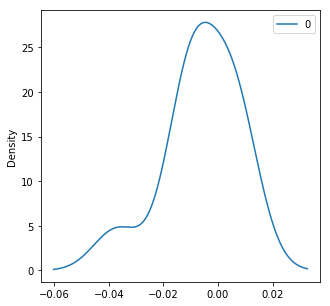

In [377]:
pd.DataFrame(pdf1).plot(kind="density",figsize=(5,5))
plt.show()

## Probability Density Function of Forged Signatures

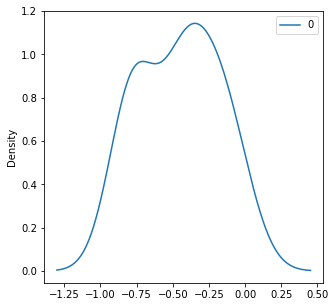

In [337]:
pd.DataFrame(pdf2).plot(kind="density",figsize=(5,5))
plt.show()

In [338]:
def AER(preds):
    ac=preds[0:10]
    FRR=len(ac[ac==-1])/len(ac)
    fg=preds[10:]
    FAR=len(fg[fg==1])/len(fg)
    AER1=(FRR+FAR)/2
    return round(AER1*100,3)

print("The average error rate with hard thresholding is ", AER(preds))
print(preds)

The average error rate with hard thresholding is  17.5
[ 1.  1.  1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


Clearly, given the small number of samples, the use of a hard threshold reduces the accuracy by a large margin, as shown in the paper. If we opt for a soft threshold, the corresponding error rate will fall.

In [314]:
def AER2(preds):
    ac=preds[0:10]
    FRR=ac.count(-1)/len(ac)
    fg=preds[10:]
    FAR=fg.count(1)/len(fg)
    AER1=(FRR+FAR)/2
    return round(AER1*100,3),FRR,FAR


In [384]:
def soft_thres(pdf,pdf1):
    m=np.mean(pdf1)
    sig=np.std(pdf1)
    best_thres=0
    best_AER=100
    best_FFR=100
    best_FAR=100
    for k in range(-300,300):
        k_d=k/100
        thres=m+k_d*sig
        preds2=[1 if x >= thres else -1 for x in pdf]
        #print(preds2)
        cur_AER,FRR,FAR=AER2(preds2)
       # print(k_d)
        if cur_AER < best_AER:
            best_AER=cur_AER
            best_thres=thres
            best_FRR=FRR
            best_FAR=FAR
           # print(best_AER,FRR,FAR)
    #print(f"The lowest possible error rate is {best_AER} at threshold = {best_thres}")
    return best_thres,best_FRR,best_FAR,best_AER




Thus, after tuning the threshold, the average error rate has dropped to 10%.

In [429]:
def fixed_soft_thres(pdf,thres):
    preds2=[1 if x >= thres else -1 for x in pdf]
    cur_AER,FRR,FAR=AER2(preds2)
    return cur_AER,FRR,FAR

## Aggregating data for 30 writers 

In [358]:
24*42

1008

In [395]:
import random
li=random.sample(range(0,55),30)
li

[5,
 16,
 19,
 54,
 43,
 33,
 49,
 34,
 50,
 17,
 29,
 15,
 21,
 37,
 18,
 32,
 10,
 20,
 51,
 47,
 48,
 24,
 35,
 36,
 44,
 8,
 3,
 41,
 45,
 14]

In [396]:
master_pdf1=np.ndarray(1)
master_pdf2=np.ndarray(1)
master_data=[]
for i in li:
    os=24*i
    #print(i)
    data=alt_df.iloc[0+os:14+os]
    #print(data.shape)
    data=data.drop("Writer_no",axis=1)
    data=data.drop("Sample_no",axis=1)
    
    li1=[os+j for j in range(0,24)]
  
    test_m=alt_df.drop(alt_df.index[li1])
    rand_signs=test_m.sample(n=20)
    
    test=alt_df.iloc[14+os:24+os]
    test=test.append(rand_signs)
    test=test.drop("Writer_no",axis=1)
    test=test.drop("Sample_no",axis=1)
    
    best_nu,best_gamma=tuning_SVM(data)
    clf = svm.OneClassSVM(nu=best_nu, kernel="rbf", gamma=best_gamma)
    clf.fit(data)
    preds=clf.predict(test)
    
    aer_h=AER(preds)

    pdf1=clf.decision_function(test[0:10])
    pdf2=clf.decision_function(test[10:])
    pdf=clf.decision_function(test)
    master_pdf1=np.append(master_pdf1,pdf1)
    master_pdf2=np.append(master_pdf2,pdf2)
    soft_t,frr,far,aer_s=soft_thres(pdf,pdf1)
    #print(master_pdf1)
    #print(f"The lowest possible error rate is {aer_s} at threshold = {soft_t}")
    x=pd.Series([i+1,best_nu,best_gamma,aer_h,soft_t,aer_s,frr,far],index=
                    ["Writer_no","Best_nu","Best_gamma","Hard_AER","Soft_Threshold","Soft_AER","FRR","FAR"])
    master_data.append(x)
    
master_df=pd.DataFrame(master_data)

## Dataset of 30 writers

In [400]:
master_df

,Writer_no,Best_nu,Best_gamma,Hard_AER,Soft_Threshold,Soft_AER,FRR,FAR
0,6.0,0.01,0.020,32.5,-0.000060,32.5,0.3,0.35
1,17.0,0.01,0.010,5.0,-0.001180,0.0,0.0,0.00
2,20.0,0.01,0.055,5.0,-0.003943,0.0,0.0,0.00
3,55.0,0.02,0.125,5.0,-0.024990,5.0,0.1,0.00
4,44.0,0.12,0.075,25.0,-0.062052,5.0,0.1,0.00
5,34.0,0.01,0.040,17.5,-0.002763,10.0,0.1,0.10
6,50.0,0.03,0.140,25.0,-0.035349,20.0,0.2,0.20
7,35.0,0.01,0.045,30.0,-0.006749,30.0,0.5,0.10
8,51.0,0.02,0.035,5.0,-0.006799,5.0,0.0,0.10
9,18.0,0.01,0.010,12.5,-0.001027,10.0,0.0,0.20


In [404]:
print("Average AER with hard thresholding is ",np.mean(master_df.Hard_AER))
print("Average AER with soft thresholding is ",np.mean(master_df.Soft_AER))
print("Average soft threshold is ",np.mean(master_df.Soft_Threshold))

Average AER with hard thresholding is  22.333333333333332
Average AER with soft thresholding is  10.166666666666666
Average soft threshold is  -0.03979182744157475


## Testing above generated numbers of remaining 25 writers
### Using average parameter and threshold value

In [419]:
nu=np.mean(master_df.Best_nu)
gamma=np.mean(master_df.Best_gamma)
thres=np.mean(master_df.Soft_Threshold)

In [426]:
li2=[]
for i in range(0,55):
    if i not in li:
        li2.append(i)


[0,
 1,
 2,
 4,
 6,
 7,
 9,
 11,
 12,
 13,
 22,
 23,
 25,
 26,
 27,
 28,
 30,
 31,
 38,
 39,
 40,
 42,
 46,
 52,
 53]

In [430]:
testing_pdf1=np.ndarray(1)
testing_pdf2=np.ndarray(1)
testing_data=[]
for i in li2:
    os=24*i
    #print(i)
    data=alt_df.iloc[0+os:14+os]
    #print(data.shape)
    data=data.drop("Writer_no",axis=1)
    data=data.drop("Sample_no",axis=1)
    
    li1=[os+j for j in range(0,24)]
  
    test_m=alt_df.drop(alt_df.index[li1])
    rand_signs=test_m.sample(n=20)
    
    test=alt_df.iloc[14+os:24+os]
    test=test.append(rand_signs)
    test=test.drop("Writer_no",axis=1)
    test=test.drop("Sample_no",axis=1)
    

    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
    clf.fit(data)
    preds=clf.predict(test)
    
    aer_h=AER(preds)

    pdf1=clf.decision_function(test[0:10])
    pdf2=clf.decision_function(test[10:])
    pdf=clf.decision_function(test)
    testing_pdf1=np.append(testing_pdf1,pdf1)
    testing_pdf2=np.append(testing_pdf2,pdf2)
    
    aer_s,frr,far=fixed_soft_thres(pdf,thres)
    

    x=pd.Series([i+1,aer_h,aer_s,frr,far],index=
                    ["Writer_no","Hard_AER","Soft_AER","FRR","FAR"])
    testing_data.append(x)
    
testing_df=pd.DataFrame(testing_data)

In [431]:
testing_df

,Writer_no,Hard_AER,Soft_AER,FRR,FAR
0,1.0,35.0,20.0,0.4,0.00
1,2.0,25.0,2.5,0.0,0.05
2,3.0,37.5,30.0,0.1,0.50
3,5.0,42.5,32.5,0.5,0.15
4,7.0,30.0,15.0,0.3,0.00
5,8.0,12.5,22.5,0.0,0.45
6,10.0,20.0,5.0,0.0,0.10
7,12.0,32.5,17.5,0.2,0.15
8,13.0,35.0,15.0,0.3,0.00
9,14.0,35.0,22.5,0.0,0.45


In [432]:
print("Average AER with hard thresholding is ",np.mean(testing_df.Hard_AER))
print("Average AER with soft thresholding is ",np.mean(testing_df.Soft_AER))


Average AER with hard thresholding is  26.9
Average AER with soft thresholding is  15.0


### The results obtained are consistent with the AERs in Guerbai et al. (2015). They report AER of between 21.04% to 32% for hard thresholding, and between 8.50% to 11.75% with soft thresholding.

## Probability Distribution Function of Real Signatures (Euclidean Distance Measure)

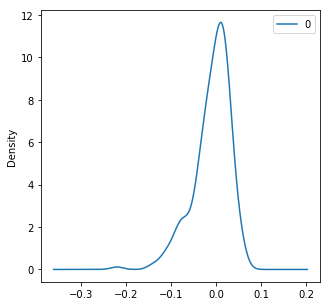

In [436]:

pd.DataFrame(testing_pdf1).plot(kind="density",figsize=(5,5))
plt.show()

## Probability Distribution Function of Forged Signatures (Euclidean Distance Measure)

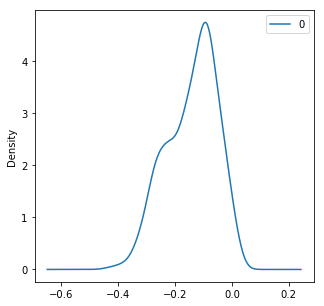

In [439]:

pd.DataFrame(testing_pdf2).plot(kind="density",figsize=(5,5))
plt.show()

# Trial work, discarded

In [9]:
import pywt

In [ ]:
r = cv2.selectROI(img)
imCrop = im[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
 
    # Display cropped image
cv2.imshow("Image", imCrop)
cv2.waitKey(0)

In [98]:
cv2.erode?

In [100]:
svm.OneClassSVM.fit?